#### Run this notebook as a sanity check for your implementation

### Creating search pipelines for two different ranking strategies.

* Pipeline 1: Initial ranking by BM25 with re-ranking by LambdaMART (Cross-encoder feature enabled)

* Pipeline 2: Initial ranking by Bi-Encoder vector ranker with re-ranking by LambdaMART (Cross-encoder feature enabled)

The corpus for the main index is augmented by doc2query queries

In [1]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import jsonlines
import numpy as np
import gzip
import os
import pickle
import pandas as pd

# your modules are imported here
from indexing import Indexer, IndexType, BasicInvertedIndex
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter
from ranker import Ranker, BM25, CrossEncoderScorer
from vector_ranker import VectorRanker
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker
from relevance import run_relevance_tests

/home/zim/.virtualenvs/SI650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change these to point to actual file paths
DRIVE_PATH = '../data/'
CACHE_PATH = '../cache/'
STOPWORD_PATH = DRIVE_PATH + 'stopwords.txt'
DATASET_PATH = DRIVE_PATH + 'NREL_All_Stations_data_available.jsonl'
MAIN_INDEX = 'main_index'
RELEVANCE_TRAIN_DATA = DRIVE_PATH + 'proj_relevance.zim.csv'
RELEVANCE_TEST_DATA = DRIVE_PATH + 'proj_relevance.zim.csv'

In [3]:
# Load in the stopwords

stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 543'

In [4]:
# Load or build Inverted Indices for the documents' main text and titles
#
# Estiamted times:
#    Document text token counting: 4 minutes
#    Document text indexing: 5 minutes
#    Title text indexing: 30 seconds
preprocessor = RegexTokenizer('\w+')

# Creating and saving the index

# main_index_path = CACHE_PATH + MAIN_INDEX
main_index = Indexer.create_index(
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 0)
# main_index.save(main_index_path)


Indexing...


 32%|███▏      | 63232/200000 [00:01<00:02, 47953.74it/s]


In [5]:
# Create an intial ranker for determining what to re-rank
# Use these with a L2RRanker and then train that L2RRanker model
#
# Estimated time (using 4 cores via n_jobs): 7 minutes

# An initial ranking with BM25 with reranking done by LambdaMART optimizing NDCG
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25)

In [6]:
ranker.query('Ann Arbor, MI, Tesla, DC Fast, apple_pay')

[(6701, 22.80787720766226),
 (9043, 22.39470727399223),
 (722, 20.574593375233388),
 (61270, 19.503791128902584),
 (30860, 19.503791128902584),
 (721, 19.106042453065108),
 (41488, 19.106042453065108),
 (45979, 19.106042453065108),
 (45980, 19.106042453065108),
 (60260, 19.106042453065108),
 (62810, 19.106042453065108),
 (62811, 19.106042453065108),
 (32074, 18.913190295599453),
 (19157, 18.724192447449404),
 (58754, 18.724192447449404),
 (58755, 18.724192447449404),
 (720, 18.357306546043304),
 (4032, 18.357306546043304),
 (41458, 18.179202917067283),
 (41460, 18.179202917067283),
 (41463, 18.00452202353168),
 (30861, 17.8331661390112),
 (21883, 15.012982591350731),
 (55474, 14.164577940449135),
 (20804, 14.033995664974125),
 (30237, 13.598396411292434),
 (30248, 13.598396411292434),
 (13094, 13.521616960744295),
 (43759, 11.65162230939717),
 (43762, 11.65162230939717),
 (7929, 11.275063013935824),
 (8892, 11.02669731713953),
 (9098, 10.830364991974935),
 (14260, 10.663172816540047),


In [8]:
scores_ranker = run_relevance_tests(RELEVANCE_TEST_DATA, ranker)
print(f'BM25 scores: {scores_ranker}')
print("MAP: ", scores_ranker['map'])
print("NDCG: ", scores_ranker['ndcg'])

Running relevance tests...


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

MAP:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
NDCG:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
BM25 scores: {'map': 0.0, 'ndcg': 0.0}
MAP:  0.0
NDCG:  0.0


In [22]:
ranker_map = [0.025, 0.05, 0.19285714285714287, 0, 0, 0.26, 0.01, 0, 0.02, 0, 0.11333333333333333, 0, 0, 0.0125, 0, 0, 0.03333333333333333, 0, 0.04857142857142857, 0, 0.16666666666666666, 0.11666666666666665, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0.15, 0]
ranker_ndcg = [0.16720121225264192, 0.1912049197383063, 0.40771619304648515, 0.0, 0.0, 0.35738444023216115, 0.0586666388908508, 0.0, 0.13279625411320248, 0.0, 0.44115113246165355, 0.04541743105845887, 0.0, 0.0716120549175052, 0.0, 0.06617289012360779, 0.16326880032415683, 0.0, 0.24276828655853022, 0.0, 0.3293683421236114, 0.3403003929241778, 0.0613262049089608, 0.07242198498924948, 0.21928535165731325, 0.0, 0.0, 0.0, 0.054633798952207324, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.17487644530347446, 0.3040695800485996, 0.13058065054168094]
pp1_map = [0, 0, 0.025, 0.01, 0.05, 0.3571428571428571, 0.014285714285714285, 0, 0.02, 0, 0.0665079365079365, 0, 0, 0, 0, 0.075, 0, 0, 0, 0, 0.1, 0, 0, 0, 0.05, 0, 0, 0.1, 0.014285714285714285, 0, 0, 0.1, 0, 0, 0, 0.1, 0.0125]
pp1_ndcg = [0.15044598817525506, 0.024114774059504164, 0.12133927614758865, 0.057290000967676655, 0.32809409741206513, 0.587523106887649, 0.06941992066371505, 0.0, 0.13279625411320248, 0.0, 0.25797972850121437, 0.0, 0.0, 0.0, 0.0, 0.4450994304378661, 0.0, 0.0, 0.0, 0.04462046518914338, 0.21888665798006005, 0.0, 0.04492063315887466, 0.0, 0.20342085232311144, 0.02138681585816852, 0.0, 0.19031326377064925, 0.07531155140665356, 0.0, 0.0, 0.2578062004518628, 0.0, 0.0, 0.453308352082741, 0.20271305336573306, 0.05075020367217313]
pp2_map = [0, 0, 0, 0, 0.1, 0.275, 0.0125, 0, 0.02, 0, 0.01111111111111111, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0.1, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0]
pp2_ndcg = [0.05709397913119477, 0.0, 0.0, 0.0, 0.35152534067883506, 0.4377205066724933, 0.06496211865470962, 0.0, 0.14843011901892328, 0.0, 0.11492845531283281, 0.0, 0.0, 0.0, 0.0, 0.31689265655728094, 0.0, 0.0, 0.0, 0.0, 0.30356357608583323, 0.0, 0.0, 0.0, 0.20342085232311144, 0.0, 0.0, 0.19031326377064925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37983770989879656, 0.20271305336573306, 0.03806265275412985]

In [23]:
df_data = []
for data in ranker_map:
    df_data.append((data, 'BM25', 'MAP'))
for data in ranker_ndcg:
    df_data.append((data, 'BM25', 'NDCG'))
for data in pp1_map:
    df_data.append((data, 'BM25+l2r', 'MAP'))
for data in pp1_ndcg:
    df_data.append((data, 'BM25+l2r', 'NDCG'))
for data in pp2_map:
    df_data.append((data, 'Vector+l2r', 'MAP'))
for data in pp2_ndcg:
    df_data.append((data, 'Vector+l2r', 'NDCG'))

In [28]:
df = pd.DataFrame(df_data, columns=['score', 'model', 'metric'])

In [25]:
import seaborn as sns

Text(0.5, 1.0, 'MAP@10 and NDCG@10 across Queries')

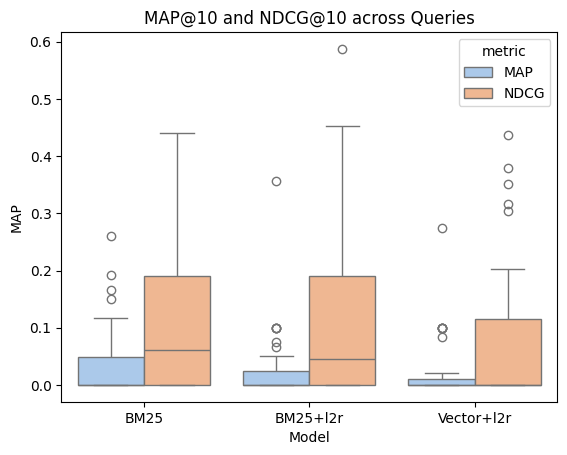

In [29]:
plot = sns.boxplot(data=df, x="model", y="score", hue="metric", palette="pastel")
plot.set_xlabel('Model')
plot.set_ylabel('MAP')
plot.set_title('MAP@10 and NDCG@10 across Queries')

In [17]:
import requests

def get_wiki_title(page_id:int):
    url = (
        'https://en.wikipedia.org/w/api.php'
        '?action=query'
        '&prop=info'
        '&inprop=subjectid'
        f'&pageids={page_id}' 
        '&format=json')
    json_response = requests.get(url).json()
    return json_response['query']['pages'][str(page_id)]['title']

After this point, students may have varying answers and observations depending on their implementation and their own features. So, your mileage may vary (YMMV)

### Example Query: 'How did the Mongols conquer China?'

This query should lead to pages about the different Mongolian invasions of China (there were multiple).

In [18]:
results = pipeline_1.query('How did the Mongols conquer China?')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
results = pipeline_2.query('How did the Mongols conquer China?')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

[('Mongol conquest of China', 0.15629720162936594),
 ('Proto-Mongols', 0.15511421967326222),
 ('Mongols in China', 0.14553224535134274),
 ('Mongols', 0.14553224535134274),
 ('Foreign relations of imperial China', 0.12819452617017554),
 ('Mongol invasions and conquests', 0.0943725611209057),
 ('Mongol conquest of the Song dynasty', 0.0943725611209057),
 ('Mongol military tactics and organization', 0.0943725611209057),
 ('Mongol conquest of Western Xia', 0.0943725611209057),
 ('Mongol invasion of the Khwarazmian Empire', 0.0943725611209057)]

**The first result is pretty similar**

But the difference is in what lies after maybe the second rank. You would see that the vector ranker would provide better pages overall in the top ranks of the fetched document list (in our experience the vector ranker pipeline focused more on conquests by mongols rather than details about mongols themselves).

### Example of a query where both the pipelines perform badly

**top 10 video games** 

In [ ]:
results = pipeline_1.query('top 10 video games')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

[('Sports video game', 0.14553224535134274),
 ('2016 in video games', 0.1379328933058825),
 ('2013 in video games', 0.1379328933058825),
 ('Breakout (video game)', 0.11870755503749891),
 ('2010s in video games', 0.11432081795467411),
 ('Centipede (video game)', 0.11101319980279584),
 ('Tile-based video game', 0.11101319980279584),
 ('Night Driver (video game)', 0.11101319980279584),
 ('Battlezone (1980 video game)', 0.11101319980279584),
 ('Video games in the United States', 0.11059455510698667)]

In [ ]:
results = pipeline_2.query('top 10 video games')[:10]
[(get_wiki_title(result['docid']),result['score']) for result in results]

[('Sports video game', 0.14553224535134274),
 ('2016 in video games', 0.1379328933058825),
 ('2013 in video games', 0.1379328933058825),
 ('Breakout (video game)', 0.11870755503749891),
 ('2010s in video games', 0.11432081795467411),
 ('Centipede (video game)', 0.11101319980279584),
 ('Tile-based video game', 0.11101319980279584),
 ('Night Driver (video game)', 0.11101319980279584),
 ('Battlezone (1980 video game)', 0.11101319980279584),
 ('Video games in the United States', 0.11059455510698667)]

Looking at the results, it doesn't seem that the search engine does very well on this query. Why might that be? Could you think of ways to handle these types of queries? What about other queries where the search engine might just not be very good?